In [1]:
"""
Adapted from Modeling and Simulation in Python, Allen Downey
"""

from pandas import read_html
filename = 'Estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')
"""
header indicates which row should be considered the header. In this 
case it is the first row.

index_col indicates which column of each table should be considered 
the index, in this case it is the first column which contains the years

decimal - normally this argument is used to indicate which character
shoild be considered a decimal point. In this case, we are overriding 
this feature by treating M as a decimal point, which allows the estimates
that are expressed in millions (M) to be read as numbers.
"""

table2 = tables[2]
"""
The result which is assigned to tables, is a sequence that contains one
dataframe for each table. Third table (numbered 2) contains population
estimates from 1950 to 2016.
"""

''' Exploring the data  
    ------------------
'''
print("head is", table2.head())
print("shape is", table2.shape)
# Out[17]: (67, 24)
print("Columns are", table2.columns)
"""
The column labels are long strings, which makes them hard to work with. 
Let's replace them with shorter strings
"""
table2.columns = ['census', 'prb', 'un', 'maddison', 'hyde',  
                  'biraben', 'mj', 'thomlison', 'durand', 'clark']
print("Revised columns are", table2.columns)

# Here are the estimates from US census bureau
# 1e9 is a shorter way to write 1000000000 or one billion
census = table2.census / 1e9
# result is a pandas series similar to timeseries
print("census.tail() is\n", census.tail())

# Here are the estimates from UN dept of economic and social affairs
un = table2.un / 1e9
print("un tail is\n", un.tail())

def plot_estimates():
    census.plot(style=':', label='US census', xlabel='Year', ylabel='World population (billions)', legend="1" )
    un.plot(style='--', label='UN DESA', legend="1", title="Data modeling")


head is       United States Census Bureau (2017)[28]  \
Year                                           
1950                              2557628654   
1951                              2594939877   
1952                              2636772306   
1953                              2682053389   
1954                              2730228104   

      Population Reference Bureau (1973–2016)[15]  \
Year                                                
1950                                 2.516000e+09   
1951                                          NaN   
1952                                          NaN   
1953                                          NaN   
1954                                          NaN   

      United Nations Department of Economic and Social Affairs (2015)[16]  \
Year                                                                        
1950                                       2.525149e+09                     
1951                                       2.572851e

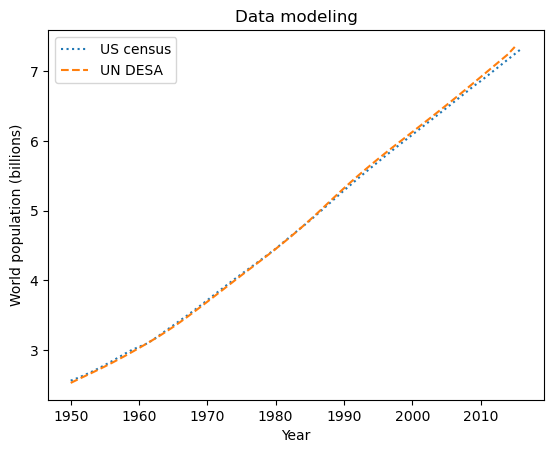

In [3]:
plot_estimates()

In [4]:
''' Absolute and relative errors  
    ----------------------------
Estimates of world population from US census and UN
DESA differ slightly. One way to characterize this
difference is absolute error, which is the absolute 
value of the difference between the estimates.
To compute absolute errors, we can import abs from NumPy
    
'''
from numpy import abs
abs_error = abs(un - census)
print("absolute error tail ", abs_error.tail())
# when you subtract two serier objects the result is a new series
from numpy import mean
print("mean abs_error", mean(abs_error))
# on average estimates diff by 0.029 billion
from numpy import max
print("max absolute error is", max(abs_error))
# In the worst case, they differ by ~0.1 billion. That is a lot of people
# another way to quantify the difference is relative error, which is error
# divided by the estimates themselves
rel_error = 100*abs_error / census
print("relative error tail", rel_error.tail())
# Now we can interpret the results as a percentage. In 2015 the difference b/w
# the estimates is ~1.4 percent which also happens to be the max
print("mean relative error", mean(rel_error))
# mean relative error is about 0.6 percent
print("max relative error", max(rel_error))


absolute error tail  Year
2012    0.066201
2013    0.069991
2014    0.073816
2015    0.101579
2016         NaN
dtype: float64
mean abs_error 0.029034508242424265
max absolute error is 0.10157921199999986
relative error tail Year
2012    0.943860
2013    0.986888
2014    1.029514
2015    1.401500
2016         NaN
dtype: float64
mean relative error 0.5946585816022846
max relative error 1.4014999251669376


In [5]:
''' Modeling population growth
    --------------------------
'''
# total_growth during 1950 and 2016 is
total_growth = census[2016] - census[1950]
t_0 = census.index[0]
t_end = census.index[-1]

elapsed_time = t_end - t_0
p_0 = census[t_0]
p_end = census[t_end]

total_growth = p_end - p_0
annual_growth = total_growth/ elapsed_time
print("annual growth", annual_growth)
# from 1950 to 2016 the world population grew by ~0.07 billion people per year


annual growth 0.07224800083333333


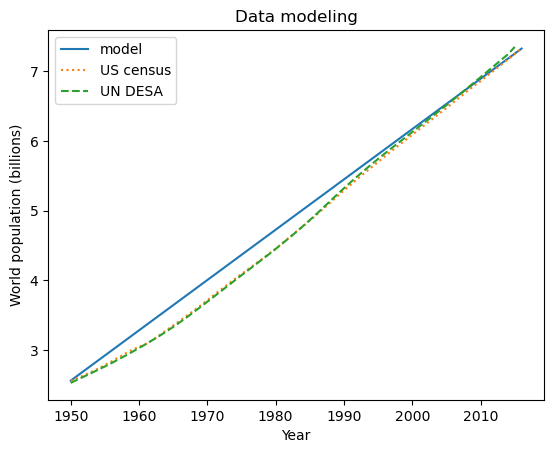

In [6]:
''' simulating population growth
    ----------------------------
'''
import pandas as pd
def TimeSeries(*args, **kwargs):
    """Make a pd.Series object to represent a time series.
    """
    if args or kwargs:
        #underride(kwargs, dtype=float)
        series = pd.Series(*args, **kwargs)
    else:
        series = pd.Series([], dtype=float)

    series.index.name = 'Time'
    if 'name' not in kwargs:
        series.name = 'Quantity'
    return series

results = TimeSeries()
results[t_0] = p_0
# Now set the rest of the values by simulating annual growth
# assuming constant growth
for t in range(t_0, t_end):
    results[t+1] = results[t] + annual_growth
results.plot(label='model', title='Constant growth model', legend="1", xlabel='Year', ylabel='World population (billions)')
# from 1950 to 1990, the model does not fit the data particularly well,
# but after that it fits ok
plot_estimates()

{'t_0': 1950, 't_end': 2016, 'p_0': 2.557628654, 'annual_growth': 0.07224800083333333}


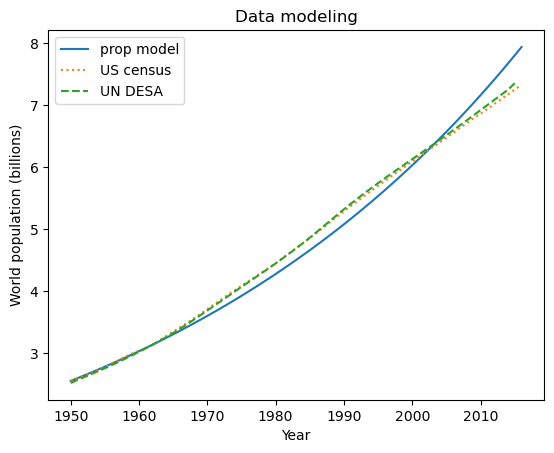

In [7]:
# system object is a dictionary that stores the state information

system = dict()
system['t_0'] = t_0
system['t_end'] = t_end
system['p_0'] = p_0
system['annual_growth'] = annual_growth

print(system)

''' Proportional growth model
    -------------------------
    growth is proportional to population
    net_growth = parameter_alpha * pop
'''

system['birth_rate'] = 25 / 1000 # such that it fits the model
# based on 2020 global rate indexmundi.com/world/death_rate.html
system['death_rate'] = 7.7 / 1000

def run_simulation(system):
    results = TimeSeries()
    results[system['t_0']] = system['p_0']
    
    for t in range(system['t_0'], system['t_end']):
        #results[t+1] = results[t] + system['annual_growth'] # constant growth
        births = system['birth_rate'] * results[t]
        deaths = system['death_rate'] * results[t]
        results[t+1] = results[t] + births - deaths
        
    return results

results_prop = run_simulation(system)
results_prop.plot(label='prop model', legend="1", xlabel='Year', ylabel='World population (billions)')
# proportional model fits the data well from 1950 to 1965 but
# not so well after that
plot_estimates()

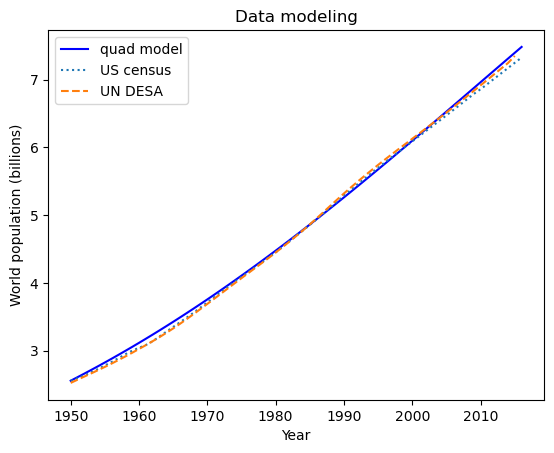

In [8]:
''' Quadratic growth
    ----------------
    net_growth = alpha*pop + beta * pop**2
'''
# these params were chosen by the author by trial and error
system['alpha'] = 25 / 1000
system['beta'] = -1.8 / 1000

def run_simulation_g(system, growth_func):
    results = TimeSeries()
    results[system['t_0']] = system['p_0']
    
    for t in range(system['t_0'], system['t_end']):
        growth = growth_func(t, results[t], system)
        results[t+1] = results[t] + growth
        
    return results

def growth_func_quad(t, pop, system):
    return system['alpha']*pop + system['beta']*pop*pop

results_quad = run_simulation_g(system, growth_func_quad)
results_quad.plot(label='quad model', legend="1", color="blue")
# The model fits the data well over the whole range with just a bit of space between them in the 1960s
plot_estimates()

projection tail Time
2096    12.462519
2097    12.494516
2098    12.525875
2099    12.556607
2100    12.586719
Name: Quantity, dtype: float64


'\nprojection tail Time\n2096    12.462519\n2097    12.494516\n2098    12.525875\n2099    12.556607\n2100    12.586719 billion\nName: Quantity, dtype: float64\n'

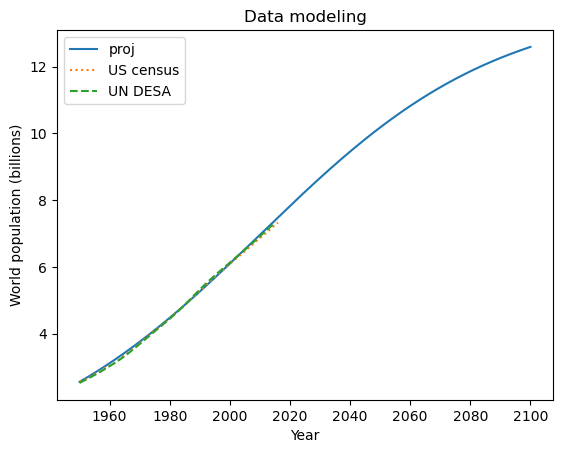

In [9]:
'''Generating Projections
   ----------------------
'''
system['t_end'] = 2100
results_far = run_simulation_g(system, growth_func_quad)
results_far.plot(label='proj', legend="1")
print("projection tail", results_far.tail())
plot_estimates()
'''
projection tail Time
2096    12.462519
2097    12.494516
2098    12.525875
2099    12.556607
2100    12.586719 billion
Name: Quantity, dtype: float64
'''
